<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo sequence to sequence - Traductor

### Consigna

Replicar y extender el traductor:
- Replicar el modelo en PyTorch.
- Extender el entrenamiento a más datos y tamaños de secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.

Extras que se pueden probar: 
- Embeddingspre-entrenados para los dos idiomas
- Cambiar la estrategia de generación (por ejemplo muestreo aleatorio)

## 1. Datos

In [93]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [94]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
from torchinfo import summary

import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [95]:
# Descargar la carpeta de dataset
import gdown
import zipfile
if os.access('spa-eng', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = os.path.join("./Dataset", "spa-eng.zip")
        gdown.download(url, output, quiet=False)
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall("./Dataset")
else:
    print("El dataset ya se encuentra descargado")

# dataset_file

text_file = os.path.join("./Dataset", "spa-eng/spa.txt")
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]


Downloading...
From: http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
To: /home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/Desafio_4/Dataset/spa-eng.zip
100%|██████████| 2.64M/2.64M [00:01<00:00, 2.05MB/s]


### Funciones de guardado del modelo

In [96]:
import json

def save_checkpoint(folder, model, optimizer, history, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix, embedding_matrix_decoder=None):
    """
    Guarda todos los elementos necesarios para reconstruir el entrenamiento.
    """
    os.makedirs(folder, exist_ok=True)

    torch.save(model.state_dict(), os.path.join(folder, "seq2seq_model.pth"))
    torch.save(optimizer.state_dict(), os.path.join(folder, "optimizer_state.pth"))
    torch.save(config, os.path.join(folder, "config.pth"))

    np.save(os.path.join(folder, "embedding_matrix.npy"), embedding_matrix)
    if embedding_matrix_decoder is not None:
        np.save(os.path.join(folder, "embedding_matrix_decoder.npy"), embedding_matrix_decoder)

    with open(os.path.join(folder, "input_tokenizer.pkl"), "wb") as f:
        pickle.dump(input_tokenizer, f)
    with open(os.path.join(folder, "output_tokenizer.pkl"), "wb") as f:
        pickle.dump(output_tokenizer, f)
    with open(os.path.join(folder, "word2idx_inputs.pkl"), "wb") as f:
        pickle.dump(word2idx_inputs, f)
    with open(os.path.join(folder, "word2idx_outputs.pkl"), "wb") as f:
        pickle.dump(word2idx_outputs, f)

    with open(os.path.join(folder, "history.json"), "w") as f:
        json.dump(history, f)

    print(f"Checkpoint guardado en: {folder}")


def load_checkpoint(folder, Encoder, Decoder, Seq2Seq, device="cpu"):
    """
    Carga todo desde una carpeta y reconstruye el modelo listo para usar.
    Retorna: model, optimizer, history, config, tokenizers, vocabularios, embedding_matrix
    """
    # 1. Configuración
    config = torch.load(os.path.join(folder, "config.pth"), map_location=device)

    # 2. Tokenizers y vocabularios
    with open(os.path.join(folder, "input_tokenizer.pkl"), "rb") as f:
        input_tokenizer = pickle.load(f)
    with open(os.path.join(folder, "output_tokenizer.pkl"), "rb") as f:
        output_tokenizer = pickle.load(f)
    with open(os.path.join(folder, "word2idx_inputs.pkl"), "rb") as f:
        word2idx_inputs = pickle.load(f)
    with open(os.path.join(folder, "word2idx_outputs.pkl"), "rb") as f:
        word2idx_outputs = pickle.load(f)

    # 3. Embedding matrices (encoder obligatoria, decoder opcional)
    embedding_matrix_encoder = np.load(os.path.join(folder, "embedding_matrix.npy"))

    path_decoder = os.path.join(folder, "embedding_matrix_decoder.npy")
    embedding_matrix_decoder = np.load(path_decoder) if os.path.exists(path_decoder) else None

    vocab_size_encoder = int(embedding_matrix_encoder.shape[0])
    # 4. Modelo
    encoder = Encoder(
        vocab_size=vocab_size_encoder,
        embedding_matrix=embedding_matrix_encoder
    )

    if embedding_matrix_decoder is not None:
        decoder = Decoder(
            vocab_size=config["num_words_output"],
            output_dim=config["num_words_output"],
            embedding_matrix=embedding_matrix_decoder
        )
    else:
        print("No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.")
        decoder = Decoder(
            vocab_size=config["num_words_output"],
            output_dim=config["num_words_output"]
        )

    model = Seq2Seq(encoder, decoder)
    model.load_state_dict(torch.load(os.path.join(folder, "seq2seq_model.pth"), map_location=device))
    model.to(device)
    model.eval()

    # 5. Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    optimizer.load_state_dict(torch.load(os.path.join(folder, "optimizer_state.pth"), map_location=device))

    # 6. Historia
    with open(os.path.join(folder, "history.json"), "r") as f:
        history = json.load(f)

    print(f"Checkpoint cargado desde: {folder}")

    return {
        "model": model,
        "optimizer": optimizer,
        "history": history,
        "config": config,
        "input_tokenizer": input_tokenizer,
        "output_tokenizer": output_tokenizer,
        "word2idx_inputs": word2idx_inputs,
        "word2idx_outputs": word2idx_outputs,
        "embedding_matrix": embedding_matrix
    }


def check_checkpoint_exists(folder):
    """
    Verifica si existen todos los archivos necesarios en la carpeta.
    Retorna True si el checkpoint está completo.
    """
    required_files = [
        "seq2seq_model.pth",
        "optimizer_state.pth",
        "config.pth",
        "embedding_matrix.npy",
        "input_tokenizer.pkl",
        "output_tokenizer.pkl",
        "word2idx_inputs.pkl",
        "word2idx_outputs.pkl",
        "history.json"
    ]

    missing = [f for f in required_files if not os.path.exists(os.path.join(folder, f))]
    if missing:
        print(f"Faltan archivos en el checkpoint: {missing}")
        return False
    print(f"Checkpoint completo encontrado en: {folder}")
    return True

## 2. Entrenamiento Baseline
Se tomará el modelo entrenado en clase como Baseline para comparación al aplicar cambios:

### 2.1. Limitación dataset

In [97]:
# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

def generar_secuencias(lines, MAX_NUM_SENTENCES=6000):
    input_sentences = []
    output_sentences = []
    output_sentences_inputs = []
    count = 0

    for line in lines:
        count += 1
        if count > MAX_NUM_SENTENCES:
            break

        if '\t' not in line:
            continue

        # Input sentence --> eng
        # output --> spa
        input_sentence, output = line.rstrip().split('\t')

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)
    return input_sentences, output_sentences, output_sentences_inputs


# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 6000
input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 6000


In [98]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2.2. Preprocesamiento

In [99]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer

def tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE=8000):
    input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
    input_tokenizer.fit_on_texts(input_sentences)
    input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

    word2idx_inputs = input_tokenizer.word_index
    print("Palabras en el vocabulario:", len(word2idx_inputs))

    max_input_len = max(len(sen) for sen in input_integer_seq)
    print("Sentencia de entrada más larga:", max_input_len)


    # A los filtros de símbolos del Tokenizer agregamos el "¿",
    # sacamos los "<>" para que no afectar nuestros tokens
    output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
    output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
    output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
    output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

    word2idx_outputs = output_tokenizer.word_index
    print("Palabras en el vocabulario:", len(word2idx_outputs))

    num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
    max_out_len = max(len(sen) for sen in output_integer_seq)
    print("Sentencia de salida más larga:", max_out_len)

    return {
        'input_tokenizer': input_tokenizer,
        'output_tokenizer': output_tokenizer,
        'input_integer_seq': input_integer_seq,
        'output_integer_seq': output_integer_seq,
        'output_input_integer_seq': output_input_integer_seq,
        'word2idx_inputs': word2idx_inputs,
        'word2idx_outputs': word2idx_outputs,
        'max_input_len': max_input_len,
        'max_out_len': max_out_len,
        'num_words_output': num_words_output
    }

# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36


In [100]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 16
max_out_len = 18

In [101]:
from torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

Cantidad de rows del dataset: 6000
encoder_input_sequences shape: (6000, 16)
decoder_input_sequences shape: (6000, 18)
decoder_output_sequences shape: (6000, 18)


In [102]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        # Para CrossEntropyLoss: guardar los targets como índices de clase (LongTensor),
        # shape = (N, seq_len), dtype = torch.int64
        self.decoder_outputs = torch.from_numpy(decoder_output).to(torch.int64)

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = num_words_output
print("Output dim", output_dim)

encoder_input_size: 16
decoder_input_size: 18
Output dim 5722


In [103]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, drop_last=True)

Tamaño del conjunto de entrenamiento: 4800
Tamaño del conjunto de validacion: 1200


### 2.3. Preparar los embeddings

In [104]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [105]:
import logging
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [106]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [107]:
# Crear la Embedding matrix de las secuencias
# en ingles


def preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE):
    embed_dim = model_embeddings.N_FEATURES
    words_not_found = []

    # word_index provieen del tokenizer

    nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1) # vocab_size
    embedding_matrix = np.zeros((nb_words, embed_dim))
    for word, i in word2idx_inputs.items():
        if i >= nb_words:
            continue
        embedding_vector = model_embeddings.get_words_embeddings(word)[0]
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            
            embedding_matrix[i] = embedding_vector
        else:
            # words not found in embedding index will be all-zeros.
            words_not_found.append(word)

    print('Número de embeddings nulos:', np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix, words_not_found, nb_words

embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE)

Número de embeddings nulos: 30


In [108]:
nb_words

3852

In [109]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(3852, 50)

### 2.4. Entrenar modelo

In [110]:
from tqdm import tqdm

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
      
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random 
            # para ver en cada vuelta que técnica se aplica
            #input = top1            

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs

encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.to(device)
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
# asegurar consistencia: output_dim igual a num_words_output usado por dataset/one-hot
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.to(device)

model = Seq2Seq(encoder, decoder)
if cuda: model.to(device)

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica


### CORREGIR ERROR
#summary(model, input_data=(data_set[0:1][0], data_set[0:1][1]))

In [111]:
from tqdm import tqdm

def sequence_acc(y_pred, y_test):
    """
    Calcula la accuracy promedio por secuencia.
    y_pred: logits (batch, seq_len, vocab_size)
    y_test: índices (batch, seq_len)
    """
    y_pred_tag = y_pred.argmax(dim=-1)  # (batch, seq_len)
    y_test_tag = y_test if y_test.ndim == 2 else y_test.argmax(dim=-1)
    acc = (y_pred_tag == y_test_tag).float().mean().item()
    return acc


def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    train_loss, train_accuracy = [], []
    valid_loss, valid_accuracy = [], []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for train_encoder_input, train_decoder_input, train_target in loop:
            optimizer.zero_grad()

            # Forward
            output = model(train_encoder_input.to(device), train_decoder_input.to(device))


            # Calcular loss en toda la secuencia (más eficiente)
            loss = criterion(
                output.reshape(-1, output.shape[-1]),
                train_target.to(device).reshape(-1)
            )

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            epoch_train_accuracy += sequence_acc(output.to(device), train_target.to(device))

        epoch_train_loss /= len(train_loader)
        epoch_train_accuracy /= len(train_loader)
        train_loss.append(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)


        # --- VALIDACIÓN COMPLETA ---
        model.eval()
        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        with torch.no_grad():
            for valid_encoder_input, valid_decoder_input, valid_target in valid_loader:
                output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))
                loss = criterion(
                    output.reshape(-1, output.shape[-1]),
                    valid_target.to(device).reshape(-1)
                )

                epoch_valid_loss += loss.item()
                epoch_valid_accuracy += sequence_acc(output.to(device), valid_target.to(device))

        epoch_valid_loss /= len(valid_loader)
        epoch_valid_accuracy /= len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch {epoch+1:02}/{epochs} | "
              f"Train loss: {epoch_train_loss:.3f} | "
              f"Train acc: {epoch_train_accuracy:.3f} | "
              f"Val loss: {epoch_valid_loss:.3f} | "
              f"Val acc: {epoch_valid_accuracy:.3f}")

    return {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }

In [112]:
carpeta = "Modelos_entrenados/Baseline"

modelo_entrenado = check_checkpoint_exists(carpeta)

if not modelo_entrenado:
    history1 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=10
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "num_layers": 1,           
        "lr": 0.1,
        "batch_size": 32,
        "epochs": 10,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history1, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder, Decoder, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history1 = data["history"]

Checkpoint completo encontrado en: Modelos_entrenados/Baseline
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Baseline


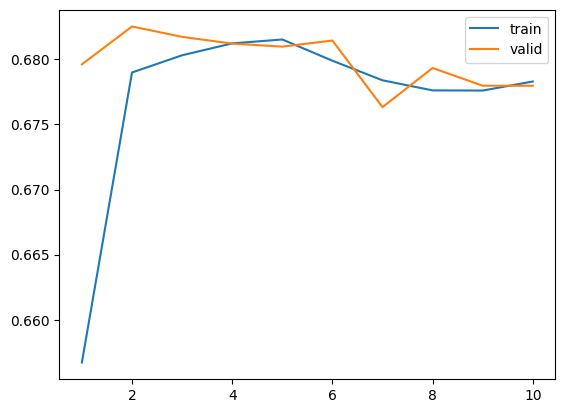

In [113]:
def graficar_accuracy(history):
    epoch_count = range(1, len(history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
    plt.show()

graficar_accuracy(history1)

### 2.5. Inferencia

In [114]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [115]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como "<sos>"
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

top1 = output.argmax(1).view(-1, 1)
idx = int(top1.cpu())
print("Index/token de salida:", idx)

word = idx2word_target[idx]
print("Palabra de salida:", word)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 225, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  15 225 134]]
Index/token de salida: 6
Palabra de salida: tom


In [116]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

In [117]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [15, 225, 134]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0  15 225 134]]
Response: tom


In [118]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: Mary wants to buy a dress.
Response: tom no quiero que


## 3. Aumentar tamaño dataset entrenamiento
Duplicamos el tamaño del dataset de entrenamiento a 12 líneas

In [119]:
MAX_NUM_SENTENCES = 12000
input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)


salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, drop_last=True)

# --- CONTROL DE ÍNDICES VÁLIDOS ---
num_words_input = len(word2idx_inputs) + 1  # +1 por padding
num_words_output = len(word2idx_outputs) + 1

encoder_input_sequences[encoder_input_sequences >= num_words_input] = 0
decoder_input_sequences[decoder_input_sequences >= num_words_output] = 0
decoder_output_sequences[decoder_output_sequences >= num_words_output] = 0





Palabras en el vocabulario: 5409
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 8584
Sentencia de salida más larga: 36


In [120]:
embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(
    model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE
)



encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_datos"

modelo_entrenado = check_checkpoint_exists(carpeta)

if not modelo_entrenado:
    history2 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=10
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "num_layers": 1,            
        "lr": 0.1,
        "batch_size": 32,
        "epochs": 10,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history2, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder, Decoder, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history2 = data["history"]


Número de embeddings nulos: 53
Checkpoint completo encontrado en: Modelos_entrenados/Aumentar_datos
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Aumentar_datos


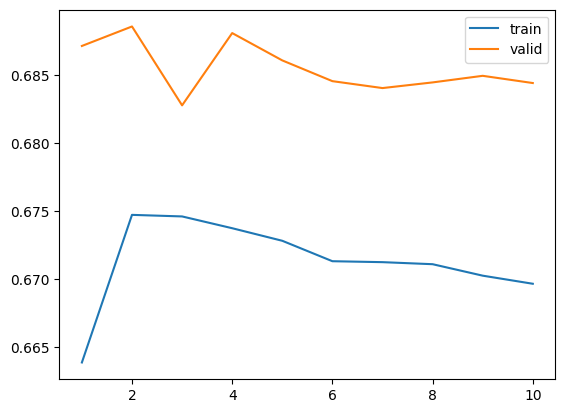

In [121]:
graficar_accuracy(history2)

## 4. Aumentar tamaño de las secuencias
Aumentamos el tamaño de input maximo a 25 (la más larga en el dataset es 32) y del output a 30 (la más larga en el dataset es 36)

In [122]:
MAX_NUM_SENTENCES = 6000
max_input_len = 25
max_out_len = 30

input_sentences, output_sentences, output_sentences_inputs = generar_secuencias(lines, MAX_NUM_SENTENCES)


salida_tokenizador = tokenizar_texto(input_sentences, output_sentences, output_sentences_inputs, MAX_VOCAB_SIZE)

input_tokenizer = salida_tokenizador["input_tokenizer"]
output_tokenizer = salida_tokenizador["output_tokenizer"]
input_integer_seq = salida_tokenizador["input_integer_seq"]
output_integer_seq = salida_tokenizador["output_integer_seq"]
output_input_integer_seq = salida_tokenizador["output_input_integer_seq"]
num_words_output = salida_tokenizador["num_words_output"]
word2idx_inputs = salida_tokenizador["word2idx_inputs"]
word2idx_outputs = salida_tokenizador["word2idx_outputs"]


encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, drop_last=True)

Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36


In [123]:
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix, words_not_found, nb_words = preparar_embedding_matrix(model_embeddings, word2idx_inputs, MAX_VOCAB_SIZE)

encoder = Encoder(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica


# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_secuencias"

modelo_entrenado = check_checkpoint_exists(carpeta)

if not modelo_entrenado:
    history3 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=10
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "num_layers": 1,           
        "lr": 0.1,
        "batch_size": 32,
        "epochs": 10,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history3, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder, Decoder, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history3 = data["history"]




Número de embeddings nulos: 30
Checkpoint completo encontrado en: Modelos_entrenados/Aumentar_secuencias
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Aumentar_secuencias


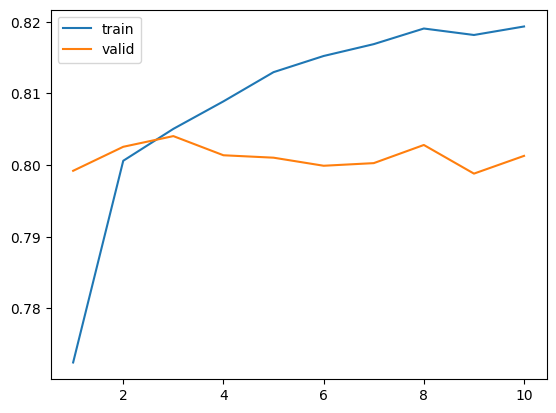

In [124]:
graficar_accuracy(history3)

Se observa una mejora significativa del accuracy respecto a las variantes anteriores, por lo que se mantiene la modificación para las siguientes variantes a entrenar:

## 5. Aumentar cantidad de hidden units de LSTM

In [125]:
class Encoder_2(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 256
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder_2(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 256
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer


    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.fc1(lstm_output[:,-1,:])
        return out, (ht, ct)

In [126]:
encoder = Encoder_2(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder_2(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_hidden_size"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 10

if not modelo_entrenado:
    history4 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 256,      
        "num_layers": 1,           
        "lr": 0.1,
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history4, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder_2, Decoder_2, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history4 = data["history"]

Checkpoint completo encontrado en: Modelos_entrenados/Aumentar_hidden_size
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Aumentar_hidden_size


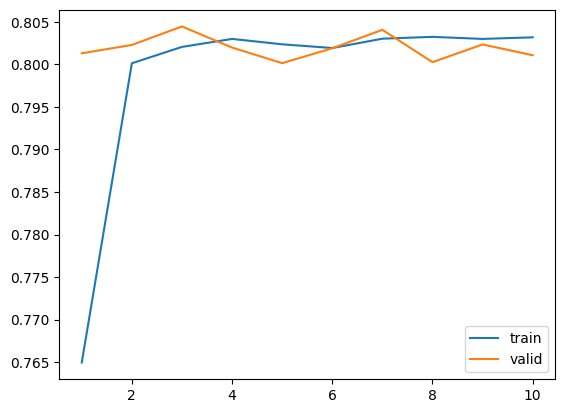

In [127]:
graficar_accuracy(history4)

## 6. Aumentar cantidad de celdas LSTM

In [128]:
class Encoder_3(nn.Module):
    def __init__(self, vocab_size, embedding_matrix):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size1 = 128
        self.lstm_size2 = 64
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        # Primer LSTM
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim,
                             hidden_size=self.lstm_size1,
                             batch_first=True,
                             num_layers=self.num_layers)

        # Segundo LSTM, recibe como input la salida del primero
        self.lstm2 = nn.LSTM(input_size=self.lstm_size1,
                             hidden_size=self.lstm_size2,
                             batch_first=True,
                             num_layers=self.num_layers)

    def forward(self, x):
        out = self.embedding(x)
        lstm_out1, (h1, c1) = self.lstm1(out)  # [batch_size, seq_len, lstm_size1]
        lstm_out2, (h2, c2) = self.lstm2(lstm_out1)  # [batch_size, seq_len, lstm_size2]

        # Retornar hidden y cell del último LSTM
        return h2, c2

class Decoder_3(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size1 = 128
        self.lstm_size2 = 64
        self.num_layers = 1 
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        # Primer LSTM
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim,
                             hidden_size=self.lstm_size1,
                             batch_first=True,
                             num_layers=self.num_layers)

        # Segundo LSTM, recibe como input la salida del primero
        self.lstm2 = nn.LSTM(input_size=self.lstm_size1,
                             hidden_size=self.lstm_size2,
                             batch_first=True,
                             num_layers=self.num_layers)

        self.fc1 = nn.Linear(in_features=self.lstm_size2, out_features=self.output_dim) # Fully connected layer


    def forward(self, x, prev_state):
        out = self.embedding(x)
        # Primera LSTM SIN estado inicial (128)
        lstm_out1, _ = self.lstm1(out)
        # Segunda LSTM CON el estado del encoder (64)
        lstm_out2, (ht2, ct2) = self.lstm2(lstm_out1, prev_state)
        out = self.fc1(lstm_out2[:,-1,:])
        return out, (ht2, ct2)

class Seq2Seq_3(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size2 == decoder.lstm_size2, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        
        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
      
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random 
            # para ver en cada vuelta que técnica se aplica
            #input = top1            

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs


In [129]:
encoder = Encoder_3(vocab_size=nb_words, embedding_matrix=embedding_matrix)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder_3(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq_3(encoder, decoder)
if cuda: model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Aumentar_capas_LSTM"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 10

if not modelo_entrenado:
    history5 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,        
        "hidden_size_lstm2": 64,
        "num_layers": 1,          
        "lr": 0.1,
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history5, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
else:
    data = load_checkpoint(carpeta, Encoder_3, Decoder_3, Seq2Seq_3, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history5 = data["history"]

Checkpoint completo encontrado en: Modelos_entrenados/Aumentar_capas_LSTM
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Aumentar_capas_LSTM


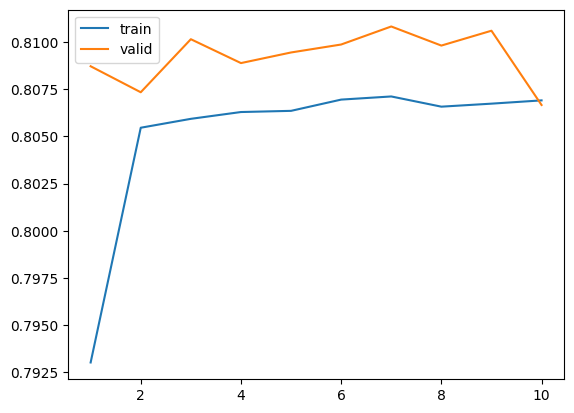

In [130]:
graficar_accuracy(history5)

## 7. LSTM bidireccional Encoder
Ahora se modifica la LSTM por una bidireccional. Esto se hace solamente en el Encoder, ya que el Decoder no puede utilizar información futura

In [131]:
class Encoder_bidireccional(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, dropout_rate=0.2):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.dropout_rate = dropout_rate
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        
        # Dropout después del embedding
        self.dropout_embedding = nn.Dropout(self.dropout_rate)
        
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers,
            bidirectional=True,
            dropout=self.dropout_rate 
        )

    def forward(self, x):
        out = self.embedding(x)
        out = self.dropout_embedding(out)  # Dropout después del embedding
        lstm_output, (ht, ct) = self.lstm(out)
        
        # CAMBIO CLAVE: Usar solo el estado forward para evitar problemas de dimensiones
        # Esto mantiene la ventaja bidireccional del encoder pero evita incompatibilidades
        ht_forward = ht[0].unsqueeze(0)  # Solo forward, shape (1, batch, 128)
        ct_forward = ct[0].unsqueeze(0)  # Solo forward, shape (1, batch, 128)
        
        return (ht_forward, ct_forward)

class Decoder_bidreccional(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None, dropout_rate=0.2):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128  # Mismo tamaño que el encoder (no bidireccional)
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        # Dropout después del embedding
        self.dropout_embedding = nn.Dropout(self.dropout_rate)

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,  # 128 - compatible con encoder
            batch_first=True,
            num_layers=self.num_layers,
            dropout=self.dropout_rate 
        )
        
        # Dropout antes de la capa final
        self.dropout_output = nn.Dropout(self.dropout_rate)
        self.fc1 = nn.Linear(self.lstm_size, self.output_dim)
        # SIN SOFTMAX - usar solo logits para evitar problemas de gradientes

    def forward(self, x, prev_state):
        out = self.embedding(x)
        out = self.dropout_embedding(out)  # Dropout después del embedding
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.dropout_output(lstm_output[:,-1,:])  # Dropout antes de la capa final
        out = self.fc1(out)  # Solo logits, sin softmax
        return out, (ht, ct)


In [132]:
# Crear el modelo bidireccional con dropout
dropout_rate = 0.2  # 20% de dropout por defecto

encoder_bidireccional = Encoder_bidireccional(vocab_size=nb_words, 
                                            embedding_matrix=embedding_matrix, 
                                            dropout_rate=dropout_rate)
if cuda: encoder_bidireccional.to(device)

# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder_bidreccional = Decoder_bidreccional(vocab_size=num_words_output, 
                                          output_dim=num_words_output,
                                          dropout_rate=dropout_rate)
if cuda: decoder_bidreccional.to(device)

model = Seq2Seq(encoder_bidireccional, decoder_bidreccional)
if cuda: model.to(device)

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Learning rate más conservador
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

print(f"✓ Modelo bidireccional creado con dropout_rate = {dropout_rate}")
print(f"✓ Learning rate = 0.01")
print(f"✓ Dispositivo: {'CUDA' if cuda else 'CPU'}")

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/LSTM_bidireccional"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 20

if not modelo_entrenado:
    print(f"\nIniciando entrenamiento por {n_epochs} épocas...")
    history6 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,      
        "num_layers": 1,           
        "lr": 0.01,  # Learning rate más conservador
        "dropout_rate": dropout_rate,  # Nuevo parámetro
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history6, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
    print("Modelo entrenado y guardado exitosamente")
else:
    print(f"\nCargando modelo existente desde {carpeta}")
    data = load_checkpoint(carpeta, Encoder_bidireccional, Decoder_bidreccional, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history6 = data["history"]
    print("Modelo cargado exitosamente")


✓ Modelo bidireccional creado con dropout_rate = 0.2
✓ Learning rate = 0.01
✓ Dispositivo: CUDA
Checkpoint completo encontrado en: Modelos_entrenados/LSTM_bidireccional

Cargando modelo existente desde Modelos_entrenados/LSTM_bidireccional
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/LSTM_bidireccional
Modelo cargado exitosamente


/home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


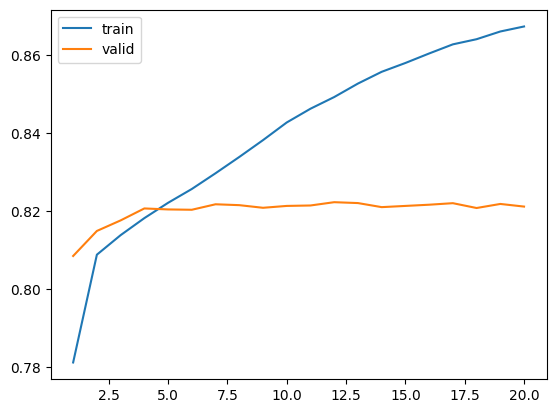

In [133]:
graficar_accuracy(history6)


## 8. Embedding de encoder entrenable

In [134]:
class Encoder_bidireccional_2(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, dropout_rate=0.2):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1]
        self.dropout_rate = dropout_rate
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        # Dropout después del embedding
        self.dropout_embedding = nn.Dropout(self.dropout_rate)
        
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers,
            bidirectional=True,
            dropout=self.dropout_rate 
        )

    def forward(self, x):
        out = self.embedding(x)
        out = self.dropout_embedding(out)  # Dropout después del embedding
        lstm_output, (ht, ct) = self.lstm(out)
        
        # CAMBIO CLAVE: Usar solo el estado forward para evitar problemas de dimensiones
        # Esto mantiene la ventaja bidireccional del encoder pero evita incompatibilidades
        ht_forward = ht[0].unsqueeze(0)  # Solo forward, shape (1, batch, 128)
        ct_forward = ct[0].unsqueeze(0)  # Solo forward, shape (1, batch, 128)
        
        return (ht_forward, ct_forward)

class Decoder_bidreccional_2(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None, dropout_rate=0.2):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128  # Mismo tamaño que el encoder (no bidireccional)
        self.num_layers = 1
        self.embedding_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)

        # Para utilizar versión con embedding preentrenados
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False  # 

        # Dropout después del embedding
        self.dropout_embedding = nn.Dropout(self.dropout_rate)

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,  # 128 - compatible con encoder
            batch_first=True,
            num_layers=self.num_layers,
            dropout=self.dropout_rate 
        )
        
        # Dropout antes de la capa final
        self.dropout_output = nn.Dropout(self.dropout_rate)
        self.fc1 = nn.Linear(self.lstm_size, self.output_dim)
        # SIN SOFTMAX - usar solo logits para evitar problemas de gradientes

    def forward(self, x, prev_state):
        out = self.embedding(x)
        out = self.dropout_embedding(out)  # Dropout después del embedding
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.dropout_output(lstm_output[:,-1,:])  # Dropout antes de la capa final
        out = self.fc1(out)  # Solo logits, sin softmax
        return out, (ht, ct)

In [135]:
# Crear el modelo bidireccional con dropout
dropout_rate = 0.2  # 20% de dropout por defecto

encoder_bidireccional = Encoder_bidireccional_2(vocab_size=nb_words, 
                                            embedding_matrix=embedding_matrix, 
                                            dropout_rate=dropout_rate)
if cuda: encoder_bidireccional.to(device)

# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder_bidreccional = Decoder_bidreccional_2(vocab_size=num_words_output, 
                                          output_dim=num_words_output,
                                          dropout_rate=dropout_rate)
if cuda: decoder_bidreccional.to(device)

model = Seq2Seq(encoder_bidireccional, decoder_bidreccional)
if cuda: model.to(device)

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Learning rate más conservador
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

print(f"✓ Modelo bidireccional creado con dropout_rate = {dropout_rate}")
print(f"✓ Learning rate = 0.01")
print(f"✓ Dispositivo: {'CUDA' if cuda else 'CPU'}")

# Verificar que si el modelo ya existe para cargarlo. Sino entrenar
carpeta = "Modelos_entrenados/Embedding_encoder_entrenable"

modelo_entrenado = check_checkpoint_exists(carpeta)

n_epochs = 20

if not modelo_entrenado:
    print(f"\nIniciando entrenamiento por {n_epochs} épocas...")
    history7 = train(model,
                    train_loader,
                    valid_loader,
                    optimizer,
                    criterion,
                    epochs=n_epochs
                    )
    config = {
        # Información general
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        # Hiperparámetros de embedding y red
        "embedding_dim": embedding_matrix.shape[1],
        "hidden_size": 128,      
        "num_layers": 1,           
        "lr": 0.01,  # Learning rate más conservador
        "dropout_rate": dropout_rate,  # Nuevo parámetro
        "batch_size": 32,
        "epochs": n_epochs,

        # Vocabularios (usar tamaños reales)
        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        # Checkpoint info (opcional)
        "embedding_source": getattr(model_embeddings, "name", "custom"),
    }
    save_checkpoint(carpeta, model, optimizer, history7, config,
                    input_tokenizer, output_tokenizer,
                    word2idx_inputs, word2idx_outputs, embedding_matrix)
    print("Modelo entrenado y guardado exitosamente")
else:
    print(f"\nCargando modelo existente desde {carpeta}")
    data = load_checkpoint(carpeta, Encoder_bidireccional, Decoder_bidreccional, Seq2Seq, device="cuda" if cuda else "cpu")
    model = data["model"]
    optimizer = data["optimizer"]
    history7 = data["history"]
    print("Modelo cargado exitosamente")


/home/agustin/Desktop/CEIA UBA/Procesamiento Lenguaje Natural I/CEIA-ProcesamientoLenguajeNaturalI/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


✓ Modelo bidireccional creado con dropout_rate = 0.2
✓ Learning rate = 0.01
✓ Dispositivo: CUDA
Checkpoint completo encontrado en: Modelos_entrenados/Embedding_encoder_entrenable

Cargando modelo existente desde Modelos_entrenados/Embedding_encoder_entrenable
No se encontró embedding_matrix_decoder.npy — se entrenará embedding en el Decoder.
Checkpoint cargado desde: Modelos_entrenados/Embedding_encoder_entrenable
Modelo cargado exitosamente


## 9. Attention

In [136]:
# ============================
# Encoder BiLSTM con ATTENTION
# ============================
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder_bidireccional_attn(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, hidden_size=128, num_layers=1, dropout_rate=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        # si querés congelar el embedding del encoder:
        # self.embedding.weight.requires_grad = False

        self.dropout_emb = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
            input_size=self.emb_dim,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )

    def forward(self, x):
        """
        x: [B, L_src]
        return:
          enc_out: [B, L_src, 2H]
          init_state: (h0, c0) con sólo la dir. forward para casar H
        """
        e = self.dropout_emb(self.embedding(x))
        enc_out, (ht, ct) = self.lstm(e)          # enc_out: [B,L,2H]
        # usar sólo forward (índice 0) para H=hidden_size
        h0 = ht[0].unsqueeze(0)                   # [1,B,H]
        c0 = ct[0].unsqueeze(0)                   # [1,B,H]
        return enc_out, (h0, c0)


# ====================================
# Decoder con ATTENTION (Luong "dot")
# - Proyecta enc_out (2H) -> H
# - scores_{t,i} = dec_t · (W_enc * enc_out_i)
# - Mask de padding en fuente
# ====================================
class Decoder_bidreccional_attn(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_matrix=None,
                 hidden_size=128, num_layers=1, dropout_rate=0.2, enc_out_dim=256):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb_dim = embedding_matrix.shape[1] if embedding_matrix is not None else 50
        self.output_dim = output_dim

        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            # si querés congelar el embedding del decoder:
            # self.embedding.weight.requires_grad = False

        self.dropout_emb = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
            input_size=self.emb_dim,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )

        # Proyección de estados del encoder (2H -> H) para "dot"
        self.enc_proj = nn.Linear(enc_out_dim, hidden_size, bias=False)
        self.dropout_out = nn.Dropout(dropout_rate)
        # Combinar [dec_t, context_t] -> vocab
        self.fc1 = nn.Linear(hidden_size * 2, output_dim)

    def forward(self, x, prev_state, enc_out, src_pad_mask=None):
        """
        x: [B, T_dec]
        prev_state: (h0,c0) [1,B,H]
        enc_out: [B, L_src, 2H]
        src_pad_mask: [B, L_src], True en PAD
        """
        B, L_src, _ = enc_out.size()

        # 1) Decoder "puro"
        emb = self.dropout_emb(self.embedding(x))               # [B,T,E]
        dec_seq, (ht, ct) = self.lstm(emb, prev_state)          # [B,T,H]

        # 2) Proyección encoder para dot
        enc_proj = self.enc_proj(enc_out)                       # [B,L_src,H]

        # 3) Scores y máscara de padding fuente
        # scores_{t,i} = dec_t · enc_proj_i
        scores = torch.bmm(dec_seq, enc_proj.transpose(1, 2))   # [B,T,L_src]
        if src_pad_mask is not None:
            # src_pad_mask True en PAD -> -inf para que no atienda ahí
            scores = scores.masked_fill(src_pad_mask.unsqueeze(1), float('-inf'))

        attn = torch.softmax(scores, dim=-1)                    # [B,T,L_src]

        # 4) Contexto
        context = torch.bmm(attn, enc_proj)                     # [B,T,H]

        # 5) Fusionar y proyectar a vocab
        fused = torch.cat([dec_seq, context], dim=-1)           # [B,T,2H]
        logits = self.fc1(self.dropout_out(fused))              # [B,T,V]
        return logits, (ht, ct), attn


# ======================
# Wrapper Seq2Seq + Attn
# ======================
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder_attn, pad_idx=0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder_attn
        self.pad_idx = pad_idx

    def forward(self, enc_in, dec_in):
        """
        enc_in: [B,L_src] (con PAD=0)
        dec_in: [B,T_dec] (teacher forcing)
        """
        # 1) Encode
        enc_out, init_state = self.encoder(enc_in)              # enc_out: [B,L,2H]

        # 2) Máscara de PAD en fuente
        src_pad_mask = (enc_in == self.pad_idx)                 # [B,L]

        # 3) Decode con atención (logits en TODOS los pasos)
        logits, _, _ = self.decoder(dec_in, init_state, enc_out, src_pad_mask)
        return logits


In [137]:
# =============== Crear modelo con ATTENTION (drop-in) ===============
dropout_rate = 0.2
hidden_size = 128
num_layers = 1
pad_idx = 0

encoder_attn = Encoder_bidireccional_attn(
    vocab_size=nb_words,
    embedding_matrix=embedding_matrix,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate
)
decoder_attn =  Decoder_bidreccional_attn(
    vocab_size=num_words_output,
    output_dim=num_words_output,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    enc_out_dim=hidden_size*2   # 2H (BiLSTM)
    # si tenés embedding del decoder en español:
    # , embedding_matrix=embedding_matrix_decoder
)

model = Seq2SeqAttention(encoder_attn, decoder_attn, pad_idx=pad_idx)
model = model.to(device)

# Optimizador y loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 1e-3 suele ir mejor que 1e-2
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

#  =============== Train o Load (mismo estilo) ===============
carpeta = "Modelos_entrenados/Embedding_encoder_con_attention"

modelo_entrenado = check_checkpoint_exists(carpeta)
n_epochs = 200

if not modelo_entrenado:
    print(f"\nIniciando entrenamiento por {n_epochs} épocas...")
    history_attn = train(
        model,
        train_loader,
        valid_loader,
        optimizer,
        criterion,
        epochs=n_epochs
    )

    config = {
        "max_input_len": max_input_len,
        "max_out_len": max_out_len,
        "max_vocab_size": MAX_VOCAB_SIZE,
        "cuda": cuda,

        "embedding_dim_enc": int(embedding_matrix.shape[1]),
        "embedding_dim_dec": int(embedding_matrix.shape[1]),  # cambia si usás embedding_matrix_decoder
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "lr": 0.001,
        "dropout_rate": dropout_rate,
        "batch_size": 32,
        "epochs": n_epochs,

        "num_words_input": int(embedding_matrix.shape[0]),
        "num_words_output": int(num_words_output),

        "embedding_source_enc": getattr(model_embeddings, "name", "custom"),
        "embedding_source_dec": "same_as_enc",  # o "spanish_pretrained" si usaste embedding_matrix_decoder
        "variant": "seq2seq_attention_luong_dot"
    }

    # Si usaste embedding_matrix_decoder, pásalo como param opcional
    save_checkpoint(
        carpeta, model, optimizer, history_attn, config,
        input_tokenizer, output_tokenizer,
        word2idx_inputs, word2idx_outputs, embedding_matrix
        # , embedding_matrix_decoder=embedding_matrix_decoder
    )
    print("Modelo entrenado y guardado exitosamente")
else:
    print(f"\nCargando modelo existente desde {carpeta}")
    data = load_checkpoint(
        carpeta,
        Encoder_bidireccional_attn, Decoder_bidreccional_attn, Seq2SeqAttention,
        device="cuda" if cuda else "cpu"
    )
    model = data["model"]
    optimizer = data["optimizer"]
    history_attn = data["history"]
    print("Modelo cargado exitosamente")


Faltan archivos en el checkpoint: ['seq2seq_model.pth', 'optimizer_state.pth', 'config.pth', 'embedding_matrix.npy', 'input_tokenizer.pkl', 'output_tokenizer.pkl', 'word2idx_inputs.pkl', 'word2idx_outputs.pkl', 'history.json']

Iniciando entrenamiento por 200 épocas...


Epoch 01/200 | Train loss: 6.273 | Train acc: 0.038 | Val loss: 5.785 | Val acc: 0.043


Epoch 02/200 | Train loss: 5.547 | Train acc: 0.045 | Val loss: 5.612 | Val acc: 0.049


Epoch 03/200 | Train loss: 5.174 | Train acc: 0.051 | Val loss: 5.363 | Val acc: 0.054


Epoch 04/200 | Train loss: 4.819 | Train acc: 0.055 | Val loss: 5.223 | Val acc: 0.057


Epoch 05/200 | Train loss: 4.485 | Train acc: 0.059 | Val loss: 5.114 | Val acc: 0.061


Epoch 06/200 | Train loss: 4.180 | Train acc: 0.063 | Val loss: 5.029 | Val acc: 0.065


Epoch 07/200 | Train loss: 3.883 | Train acc: 0.069 | Val loss: 5.015 | Val acc: 0.068


Epoch 08/200 | Train loss: 3.622 | Train acc: 0.073 | Val loss: 4.983 | Val acc: 0.071


Epoch 09/200 | Train loss: 3.360 | Train acc: 0.078 | Val loss: 5.008 | Val acc: 0.071


Epoch 10/200 | Train loss: 3.116 | Train acc: 0.085 | Val loss: 5.016 | Val acc: 0.074


Epoch 11/200 | Train loss: 2.902 | Train acc: 0.093 | Val loss: 5.050 | Val acc: 0.075


Epoch 12/200 | Train loss: 2.709 | Train acc: 0.100 | Val loss: 5.079 | Val acc: 0.076


Epoch 13/200 | Train loss: 2.522 | Train acc: 0.108 | Val loss: 5.083 | Val acc: 0.078


Epoch 14/200 | Train loss: 2.372 | Train acc: 0.113 | Val loss: 5.147 | Val acc: 0.078


Epoch 15/200 | Train loss: 2.235 | Train acc: 0.119 | Val loss: 5.125 | Val acc: 0.081


Epoch 16/200 | Train loss: 2.116 | Train acc: 0.124 | Val loss: 5.143 | Val acc: 0.081


Epoch 17/200 | Train loss: 2.007 | Train acc: 0.129 | Val loss: 5.157 | Val acc: 0.082


Epoch 18/200 | Train loss: 1.905 | Train acc: 0.133 | Val loss: 5.211 | Val acc: 0.082


Epoch 19/200 | Train loss: 1.821 | Train acc: 0.136 | Val loss: 5.214 | Val acc: 0.085


Epoch 20/200 | Train loss: 1.732 | Train acc: 0.140 | Val loss: 5.223 | Val acc: 0.085


Epoch 21/200 | Train loss: 1.663 | Train acc: 0.144 | Val loss: 5.240 | Val acc: 0.085


Epoch 22/200 | Train loss: 1.587 | Train acc: 0.147 | Val loss: 5.233 | Val acc: 0.085


Epoch 23/200 | Train loss: 1.529 | Train acc: 0.150 | Val loss: 5.306 | Val acc: 0.087


Epoch 24/200 | Train loss: 1.480 | Train acc: 0.152 | Val loss: 5.288 | Val acc: 0.086


Epoch 25/200 | Train loss: 1.409 | Train acc: 0.155 | Val loss: 5.328 | Val acc: 0.088


Epoch 26/200 | Train loss: 1.358 | Train acc: 0.158 | Val loss: 5.310 | Val acc: 0.088


Epoch 27/200 | Train loss: 1.296 | Train acc: 0.161 | Val loss: 5.313 | Val acc: 0.089


Epoch 28/200 | Train loss: 1.261 | Train acc: 0.163 | Val loss: 5.359 | Val acc: 0.089


Epoch 29/200 | Train loss: 1.212 | Train acc: 0.165 | Val loss: 5.340 | Val acc: 0.089


Epoch 30/200 | Train loss: 1.177 | Train acc: 0.167 | Val loss: 5.355 | Val acc: 0.089


Epoch 31/200 | Train loss: 1.141 | Train acc: 0.168 | Val loss: 5.396 | Val acc: 0.090


Epoch 32/200 | Train loss: 1.104 | Train acc: 0.170 | Val loss: 5.396 | Val acc: 0.090


Epoch 33/200 | Train loss: 1.060 | Train acc: 0.173 | Val loss: 5.418 | Val acc: 0.090


Epoch 34/200 | Train loss: 1.026 | Train acc: 0.174 | Val loss: 5.437 | Val acc: 0.090


Epoch 35/200 | Train loss: 1.004 | Train acc: 0.176 | Val loss: 5.478 | Val acc: 0.091


Epoch 36/200 | Train loss: 0.984 | Train acc: 0.177 | Val loss: 5.439 | Val acc: 0.090


Epoch 37/200 | Train loss: 0.951 | Train acc: 0.179 | Val loss: 5.484 | Val acc: 0.092


Epoch 38/200 | Train loss: 0.919 | Train acc: 0.180 | Val loss: 5.502 | Val acc: 0.092


Epoch 39/200 | Train loss: 0.889 | Train acc: 0.182 | Val loss: 5.479 | Val acc: 0.092


Epoch 40/200 | Train loss: 0.874 | Train acc: 0.182 | Val loss: 5.517 | Val acc: 0.092


Epoch 41/200 | Train loss: 0.842 | Train acc: 0.185 | Val loss: 5.559 | Val acc: 0.093


Epoch 42/200 | Train loss: 0.824 | Train acc: 0.186 | Val loss: 5.581 | Val acc: 0.093


Epoch 43/200 | Train loss: 0.792 | Train acc: 0.188 | Val loss: 5.613 | Val acc: 0.092


Epoch 44/200 | Train loss: 0.771 | Train acc: 0.189 | Val loss: 5.656 | Val acc: 0.092


Epoch 45/200 | Train loss: 0.769 | Train acc: 0.188 | Val loss: 5.597 | Val acc: 0.093


Epoch 46/200 | Train loss: 0.741 | Train acc: 0.191 | Val loss: 5.601 | Val acc: 0.093


Epoch 47/200 | Train loss: 0.728 | Train acc: 0.190 | Val loss: 5.617 | Val acc: 0.093


Epoch 48/200 | Train loss: 0.707 | Train acc: 0.192 | Val loss: 5.605 | Val acc: 0.094


Epoch 49/200 | Train loss: 0.683 | Train acc: 0.194 | Val loss: 5.719 | Val acc: 0.093


Epoch 50/200 | Train loss: 0.665 | Train acc: 0.194 | Val loss: 5.665 | Val acc: 0.094


Epoch 51/200 | Train loss: 0.650 | Train acc: 0.196 | Val loss: 5.695 | Val acc: 0.093


Epoch 52/200 | Train loss: 0.633 | Train acc: 0.197 | Val loss: 5.768 | Val acc: 0.094


Epoch 53/200 | Train loss: 0.611 | Train acc: 0.198 | Val loss: 5.737 | Val acc: 0.094


Epoch 54/200 | Train loss: 0.599 | Train acc: 0.198 | Val loss: 5.795 | Val acc: 0.095


Epoch 55/200 | Train loss: 0.587 | Train acc: 0.199 | Val loss: 5.820 | Val acc: 0.094


Epoch 56/200 | Train loss: 0.573 | Train acc: 0.200 | Val loss: 5.733 | Val acc: 0.094


Epoch 57/200 | Train loss: 0.561 | Train acc: 0.201 | Val loss: 5.797 | Val acc: 0.094


Epoch 58/200 | Train loss: 0.562 | Train acc: 0.200 | Val loss: 5.819 | Val acc: 0.094


Epoch 59/200 | Train loss: 0.542 | Train acc: 0.202 | Val loss: 5.855 | Val acc: 0.094


Epoch 60/200 | Train loss: 0.529 | Train acc: 0.203 | Val loss: 5.850 | Val acc: 0.094


Epoch 61/200 | Train loss: 0.523 | Train acc: 0.203 | Val loss: 5.894 | Val acc: 0.094


Epoch 62/200 | Train loss: 0.509 | Train acc: 0.204 | Val loss: 5.863 | Val acc: 0.094


Epoch 63/200 | Train loss: 0.490 | Train acc: 0.205 | Val loss: 5.922 | Val acc: 0.095


Epoch 64/200 | Train loss: 0.487 | Train acc: 0.205 | Val loss: 5.925 | Val acc: 0.095


Epoch 65/200 | Train loss: 0.471 | Train acc: 0.207 | Val loss: 5.951 | Val acc: 0.095


Epoch 66/200 | Train loss: 0.473 | Train acc: 0.206 | Val loss: 5.913 | Val acc: 0.096


Epoch 67/200 | Train loss: 0.453 | Train acc: 0.207 | Val loss: 5.928 | Val acc: 0.096


Epoch 68/200 | Train loss: 0.457 | Train acc: 0.207 | Val loss: 5.916 | Val acc: 0.096


Epoch 69/200 | Train loss: 0.441 | Train acc: 0.209 | Val loss: 5.951 | Val acc: 0.095


Epoch 70/200 | Train loss: 0.431 | Train acc: 0.209 | Val loss: 5.953 | Val acc: 0.096


Epoch 71/200 | Train loss: 0.428 | Train acc: 0.209 | Val loss: 5.972 | Val acc: 0.095


Epoch 72/200 | Train loss: 0.415 | Train acc: 0.210 | Val loss: 5.967 | Val acc: 0.095


Epoch 73/200 | Train loss: 0.419 | Train acc: 0.209 | Val loss: 6.059 | Val acc: 0.095


Epoch 74/200 | Train loss: 0.398 | Train acc: 0.211 | Val loss: 6.043 | Val acc: 0.097


Epoch 75/200 | Train loss: 0.394 | Train acc: 0.211 | Val loss: 6.049 | Val acc: 0.097


Epoch 76/200 | Train loss: 0.386 | Train acc: 0.212 | Val loss: 6.051 | Val acc: 0.096


Epoch 77/200 | Train loss: 0.380 | Train acc: 0.212 | Val loss: 6.048 | Val acc: 0.097


Epoch 78/200 | Train loss: 0.369 | Train acc: 0.213 | Val loss: 6.053 | Val acc: 0.096


Epoch 79/200 | Train loss: 0.369 | Train acc: 0.213 | Val loss: 6.100 | Val acc: 0.097


Epoch 80/200 | Train loss: 0.358 | Train acc: 0.213 | Val loss: 6.134 | Val acc: 0.097


Epoch 81/200 | Train loss: 0.354 | Train acc: 0.214 | Val loss: 6.104 | Val acc: 0.097


Epoch 82/200 | Train loss: 0.344 | Train acc: 0.214 | Val loss: 6.190 | Val acc: 0.097


Epoch 83/200 | Train loss: 0.335 | Train acc: 0.215 | Val loss: 6.129 | Val acc: 0.097


Epoch 84/200 | Train loss: 0.327 | Train acc: 0.215 | Val loss: 6.188 | Val acc: 0.097


Epoch 85/200 | Train loss: 0.327 | Train acc: 0.215 | Val loss: 6.205 | Val acc: 0.097


Epoch 86/200 | Train loss: 0.324 | Train acc: 0.215 | Val loss: 6.217 | Val acc: 0.096


Epoch 87/200 | Train loss: 0.328 | Train acc: 0.216 | Val loss: 6.172 | Val acc: 0.096


Epoch 88/200 | Train loss: 0.317 | Train acc: 0.217 | Val loss: 6.192 | Val acc: 0.097


Epoch 89/200 | Train loss: 0.307 | Train acc: 0.217 | Val loss: 6.290 | Val acc: 0.096


Epoch 90/200 | Train loss: 0.307 | Train acc: 0.217 | Val loss: 6.278 | Val acc: 0.096


Epoch 91/200 | Train loss: 0.302 | Train acc: 0.217 | Val loss: 6.218 | Val acc: 0.097


Epoch 92/200 | Train loss: 0.288 | Train acc: 0.219 | Val loss: 6.320 | Val acc: 0.097


Epoch 93/200 | Train loss: 0.292 | Train acc: 0.218 | Val loss: 6.336 | Val acc: 0.096


Epoch 94/200 | Train loss: 0.291 | Train acc: 0.218 | Val loss: 6.304 | Val acc: 0.096


Epoch 95/200 | Train loss: 0.289 | Train acc: 0.218 | Val loss: 6.322 | Val acc: 0.097


Epoch 96/200 | Train loss: 0.286 | Train acc: 0.218 | Val loss: 6.351 | Val acc: 0.097


Epoch 97/200 | Train loss: 0.281 | Train acc: 0.218 | Val loss: 6.356 | Val acc: 0.097


Epoch 98/200 | Train loss: 0.279 | Train acc: 0.219 | Val loss: 6.362 | Val acc: 0.098


Epoch 99/200 | Train loss: 0.268 | Train acc: 0.219 | Val loss: 6.330 | Val acc: 0.097


Epoch 100/200 | Train loss: 0.266 | Train acc: 0.220 | Val loss: 6.352 | Val acc: 0.097


Epoch 101/200 | Train loss: 0.258 | Train acc: 0.220 | Val loss: 6.434 | Val acc: 0.097


Epoch 102/200 | Train loss: 0.256 | Train acc: 0.220 | Val loss: 6.399 | Val acc: 0.097


Epoch 103/200 | Train loss: 0.247 | Train acc: 0.221 | Val loss: 6.443 | Val acc: 0.097


Epoch 104/200 | Train loss: 0.246 | Train acc: 0.221 | Val loss: 6.444 | Val acc: 0.096


Epoch 105/200 | Train loss: 0.242 | Train acc: 0.221 | Val loss: 6.519 | Val acc: 0.097


Epoch 106/200 | Train loss: 0.237 | Train acc: 0.222 | Val loss: 6.522 | Val acc: 0.096


Epoch 107/200 | Train loss: 0.245 | Train acc: 0.221 | Val loss: 6.476 | Val acc: 0.097


Epoch 108/200 | Train loss: 0.246 | Train acc: 0.221 | Val loss: 6.464 | Val acc: 0.097


Epoch 109/200 | Train loss: 0.242 | Train acc: 0.221 | Val loss: 6.475 | Val acc: 0.097


Epoch 110/200 | Train loss: 0.236 | Train acc: 0.221 | Val loss: 6.470 | Val acc: 0.098


Epoch 111/200 | Train loss: 0.233 | Train acc: 0.222 | Val loss: 6.482 | Val acc: 0.097


Epoch 112/200 | Train loss: 0.229 | Train acc: 0.223 | Val loss: 6.510 | Val acc: 0.097


Epoch 113/200 | Train loss: 0.222 | Train acc: 0.223 | Val loss: 6.530 | Val acc: 0.098


Epoch 114/200 | Train loss: 0.236 | Train acc: 0.222 | Val loss: 6.479 | Val acc: 0.096


Epoch 115/200 | Train loss: 0.228 | Train acc: 0.222 | Val loss: 6.538 | Val acc: 0.097


Epoch 116/200 | Train loss: 0.217 | Train acc: 0.223 | Val loss: 6.518 | Val acc: 0.098


Epoch 117/200 | Train loss: 0.224 | Train acc: 0.223 | Val loss: 6.595 | Val acc: 0.098


Epoch 118/200 | Train loss: 0.212 | Train acc: 0.223 | Val loss: 6.526 | Val acc: 0.097


Epoch 119/200 | Train loss: 0.213 | Train acc: 0.223 | Val loss: 6.568 | Val acc: 0.098


Epoch 120/200 | Train loss: 0.205 | Train acc: 0.224 | Val loss: 6.557 | Val acc: 0.097


Epoch 121/200 | Train loss: 0.204 | Train acc: 0.223 | Val loss: 6.560 | Val acc: 0.097


Epoch 122/200 | Train loss: 0.209 | Train acc: 0.224 | Val loss: 6.501 | Val acc: 0.098


Epoch 123/200 | Train loss: 0.206 | Train acc: 0.224 | Val loss: 6.571 | Val acc: 0.098


Epoch 124/200 | Train loss: 0.206 | Train acc: 0.224 | Val loss: 6.619 | Val acc: 0.098


Epoch 125/200 | Train loss: 0.199 | Train acc: 0.224 | Val loss: 6.601 | Val acc: 0.098


Epoch 126/200 | Train loss: 0.193 | Train acc: 0.225 | Val loss: 6.581 | Val acc: 0.098


Epoch 127/200 | Train loss: 0.203 | Train acc: 0.224 | Val loss: 6.586 | Val acc: 0.098


Epoch 128/200 | Train loss: 0.195 | Train acc: 0.224 | Val loss: 6.635 | Val acc: 0.097


Epoch 129/200 | Train loss: 0.193 | Train acc: 0.225 | Val loss: 6.623 | Val acc: 0.098


Epoch 130/200 | Train loss: 0.195 | Train acc: 0.224 | Val loss: 6.650 | Val acc: 0.098


Epoch 131/200 | Train loss: 0.191 | Train acc: 0.225 | Val loss: 6.652 | Val acc: 0.099


Epoch 132/200 | Train loss: 0.185 | Train acc: 0.225 | Val loss: 6.699 | Val acc: 0.098


Epoch 133/200 | Train loss: 0.190 | Train acc: 0.225 | Val loss: 6.665 | Val acc: 0.099


Epoch 134/200 | Train loss: 0.189 | Train acc: 0.225 | Val loss: 6.694 | Val acc: 0.098


Epoch 135/200 | Train loss: 0.184 | Train acc: 0.225 | Val loss: 6.685 | Val acc: 0.098


Epoch 136/200 | Train loss: 0.196 | Train acc: 0.224 | Val loss: 6.657 | Val acc: 0.099


Epoch 137/200 | Train loss: 0.186 | Train acc: 0.225 | Val loss: 6.705 | Val acc: 0.097


Epoch 138/200 | Train loss: 0.177 | Train acc: 0.226 | Val loss: 6.694 | Val acc: 0.098


Epoch 139/200 | Train loss: 0.178 | Train acc: 0.226 | Val loss: 6.732 | Val acc: 0.097


Epoch 140/200 | Train loss: 0.173 | Train acc: 0.226 | Val loss: 6.763 | Val acc: 0.098


Epoch 141/200 | Train loss: 0.176 | Train acc: 0.226 | Val loss: 6.825 | Val acc: 0.098


Epoch 142/200 | Train loss: 0.179 | Train acc: 0.226 | Val loss: 6.709 | Val acc: 0.098


Epoch 143/200 | Train loss: 0.179 | Train acc: 0.226 | Val loss: 6.754 | Val acc: 0.098


Epoch 144/200 | Train loss: 0.170 | Train acc: 0.226 | Val loss: 6.773 | Val acc: 0.098


Epoch 145/200 | Train loss: 0.172 | Train acc: 0.226 | Val loss: 6.747 | Val acc: 0.099


Epoch 146/200 | Train loss: 0.167 | Train acc: 0.226 | Val loss: 6.767 | Val acc: 0.098


Epoch 147/200 | Train loss: 0.162 | Train acc: 0.227 | Val loss: 6.767 | Val acc: 0.098


Epoch 148/200 | Train loss: 0.153 | Train acc: 0.227 | Val loss: 6.828 | Val acc: 0.099


Epoch 149/200 | Train loss: 0.158 | Train acc: 0.227 | Val loss: 6.750 | Val acc: 0.098


Epoch 150/200 | Train loss: 0.161 | Train acc: 0.227 | Val loss: 6.875 | Val acc: 0.098


Epoch 151/200 | Train loss: 0.159 | Train acc: 0.227 | Val loss: 6.818 | Val acc: 0.098


Epoch 152/200 | Train loss: 0.161 | Train acc: 0.227 | Val loss: 6.823 | Val acc: 0.098


Epoch 153/200 | Train loss: 0.160 | Train acc: 0.227 | Val loss: 6.835 | Val acc: 0.098


Epoch 154/200 | Train loss: 0.158 | Train acc: 0.227 | Val loss: 6.843 | Val acc: 0.098


Epoch 155/200 | Train loss: 0.148 | Train acc: 0.227 | Val loss: 6.867 | Val acc: 0.098


Epoch 156/200 | Train loss: 0.152 | Train acc: 0.227 | Val loss: 6.808 | Val acc: 0.098


Epoch 157/200 | Train loss: 0.150 | Train acc: 0.227 | Val loss: 6.865 | Val acc: 0.099


Epoch 158/200 | Train loss: 0.150 | Train acc: 0.227 | Val loss: 6.821 | Val acc: 0.099


Epoch 159/200 | Train loss: 0.160 | Train acc: 0.227 | Val loss: 6.887 | Val acc: 0.099


Epoch 160/200 | Train loss: 0.153 | Train acc: 0.227 | Val loss: 6.841 | Val acc: 0.099


Epoch 161/200 | Train loss: 0.154 | Train acc: 0.227 | Val loss: 6.872 | Val acc: 0.098


Epoch 162/200 | Train loss: 0.148 | Train acc: 0.228 | Val loss: 6.909 | Val acc: 0.098


Epoch 163/200 | Train loss: 0.149 | Train acc: 0.228 | Val loss: 6.904 | Val acc: 0.098


Epoch 164/200 | Train loss: 0.147 | Train acc: 0.228 | Val loss: 6.975 | Val acc: 0.099


Epoch 165/200 | Train loss: 0.142 | Train acc: 0.228 | Val loss: 6.978 | Val acc: 0.099


Epoch 166/200 | Train loss: 0.141 | Train acc: 0.228 | Val loss: 6.987 | Val acc: 0.098


Epoch 167/200 | Train loss: 0.151 | Train acc: 0.227 | Val loss: 6.934 | Val acc: 0.099


Epoch 168/200 | Train loss: 0.150 | Train acc: 0.227 | Val loss: 6.914 | Val acc: 0.099


Epoch 169/200 | Train loss: 0.145 | Train acc: 0.228 | Val loss: 6.976 | Val acc: 0.099


Epoch 170/200 | Train loss: 0.142 | Train acc: 0.228 | Val loss: 6.921 | Val acc: 0.098


Epoch 171/200 | Train loss: 0.139 | Train acc: 0.228 | Val loss: 6.958 | Val acc: 0.100


Epoch 172/200 | Train loss: 0.141 | Train acc: 0.228 | Val loss: 6.966 | Val acc: 0.099


Epoch 173/200 | Train loss: 0.132 | Train acc: 0.229 | Val loss: 6.982 | Val acc: 0.099


Epoch 174/200 | Train loss: 0.140 | Train acc: 0.228 | Val loss: 6.977 | Val acc: 0.099


Epoch 175/200 | Train loss: 0.144 | Train acc: 0.228 | Val loss: 6.917 | Val acc: 0.098


Epoch 176/200 | Train loss: 0.138 | Train acc: 0.228 | Val loss: 6.930 | Val acc: 0.099


Epoch 177/200 | Train loss: 0.135 | Train acc: 0.229 | Val loss: 6.954 | Val acc: 0.099


Epoch 178/200 | Train loss: 0.134 | Train acc: 0.229 | Val loss: 6.990 | Val acc: 0.098


Epoch 179/200 | Train loss: 0.134 | Train acc: 0.229 | Val loss: 7.027 | Val acc: 0.098


Epoch 180/200 | Train loss: 0.137 | Train acc: 0.229 | Val loss: 7.037 | Val acc: 0.098


Epoch 181/200 | Train loss: 0.131 | Train acc: 0.229 | Val loss: 7.010 | Val acc: 0.099


Epoch 182/200 | Train loss: 0.130 | Train acc: 0.229 | Val loss: 6.987 | Val acc: 0.099


Epoch 183/200 | Train loss: 0.137 | Train acc: 0.228 | Val loss: 6.962 | Val acc: 0.100


Epoch 184/200 | Train loss: 0.133 | Train acc: 0.229 | Val loss: 7.007 | Val acc: 0.100


Epoch 185/200 | Train loss: 0.137 | Train acc: 0.228 | Val loss: 6.966 | Val acc: 0.100


Epoch 186/200 | Train loss: 0.135 | Train acc: 0.229 | Val loss: 7.068 | Val acc: 0.099


Epoch 187/200 | Train loss: 0.135 | Train acc: 0.229 | Val loss: 7.063 | Val acc: 0.101


Epoch 188/200 | Train loss: 0.129 | Train acc: 0.229 | Val loss: 7.062 | Val acc: 0.100


Epoch 189/200 | Train loss: 0.127 | Train acc: 0.229 | Val loss: 7.049 | Val acc: 0.099


Epoch 190/200 | Train loss: 0.136 | Train acc: 0.229 | Val loss: 7.044 | Val acc: 0.099


Epoch 191/200 | Train loss: 0.130 | Train acc: 0.229 | Val loss: 7.076 | Val acc: 0.099


Epoch 192/200 | Train loss: 0.126 | Train acc: 0.229 | Val loss: 7.051 | Val acc: 0.099


Epoch 193/200 | Train loss: 0.135 | Train acc: 0.229 | Val loss: 7.072 | Val acc: 0.099


Epoch 194/200 | Train loss: 0.124 | Train acc: 0.229 | Val loss: 7.071 | Val acc: 0.100


Epoch 195/200 | Train loss: 0.131 | Train acc: 0.229 | Val loss: 7.052 | Val acc: 0.098


Epoch 196/200 | Train loss: 0.126 | Train acc: 0.229 | Val loss: 7.100 | Val acc: 0.100


Epoch 197/200 | Train loss: 0.123 | Train acc: 0.230 | Val loss: 7.104 | Val acc: 0.099


Epoch 198/200 | Train loss: 0.124 | Train acc: 0.229 | Val loss: 7.057 | Val acc: 0.099


Epoch 199/200 | Train loss: 0.126 | Train acc: 0.229 | Val loss: 7.068 | Val acc: 0.099


Epoch 200/200 | Train loss: 0.118 | Train acc: 0.230 | Val loss: 7.150 | Val acc: 0.099
Checkpoint guardado en: Modelos_entrenados/Embedding_encoder_con_attention
Modelo entrenado y guardado exitosamente


## Generar inferencias

In [138]:
# ===============================================================
# Reconstruir idx2word_outputs si no existe
# ===============================================================
if 'idx2word_outputs' not in globals():
    if 'output_tokenizer' in globals() and hasattr(output_tokenizer, 'index_word'):
        idx2word_outputs = output_tokenizer.index_word
    elif 'word2idx_outputs' in globals():
        idx2word_outputs = {v: k for k, v in word2idx_outputs.items()}
    else:
        raise ValueError("No se encontró ni 'output_tokenizer' ni 'word2idx_outputs'.")


@torch.no_grad()
def greedy_decode(model, encoder_input, sos_idx, eos_idx, max_len, device, pad_idx=0):
    """
    Decodificación Greedy para un modelo Seq2Seq:
    - model(encoder_input, decoder_input) -> logits [B, T, V]
    """
    model.eval()
    if encoder_input.dim() == 1:
        encoder_input = encoder_input.unsqueeze(0)
    encoder_input = encoder_input.to(device)

    dec = torch.full((1, 1), sos_idx, dtype=torch.long, device=device)

    for _ in range(max_len):
        logits = model(encoder_input, dec)
        next_token = logits[:, -1, :].argmax(dim=-1)
        #  Forzamos el token al mismo device que dec
        next_token = next_token.to(device)
        dec = torch.cat([dec, next_token.unsqueeze(1)], dim=1)
        if next_token.item() == eos_idx:
            break

    return dec.squeeze(0).tolist()[1:]  # sin <sos>


@torch.no_grad()
def beam_search_decode(model, encoder_input, sos_idx, eos_idx, max_len, device,
                       beam_size=5, length_penalty=1.0, pad_idx=0,
                       temperature=1.0, top_k=None):
    """
    Beam Search estándar para Seq2Seq.
    """
    model.eval()
    if encoder_input.dim() == 1:
        encoder_input = encoder_input.unsqueeze(0)
    encoder_input = encoder_input.to(device)

    beams = [(0.0, torch.full((1, 1), sos_idx, dtype=torch.long, device=device))]
    finished = []

    for _ in range(max_len):
        new_beams = []
        for logp, seq in beams:
            if seq[0, -1].item() == eos_idx:
                finished.append((logp, seq.clone()))
                continue

            logits = model(encoder_input, seq)[:, -1, :]
            if temperature != 1.0:
                logits /= temperature

            if top_k is not None and 0 < top_k < logits.size(-1):
                topk_vals, topk_idx = torch.topk(logits, k=top_k, dim=-1)
                log_probs = F.log_softmax(topk_vals, dim=-1)
                cand_ids = topk_idx.squeeze(0)
            else:
                log_probs = F.log_softmax(logits, dim=-1)
                cand_ids = torch.arange(log_probs.size(-1), device=device)

            log_probs = log_probs.squeeze(0)
            topk_logp, topk_id = torch.topk(log_probs, k=min(beam_size, log_probs.numel()))
            for add_logp, token_rank in zip(topk_logp.tolist(), topk_id.tolist()):
                token_id = cand_ids[token_rank].item()
                new_seq = torch.cat([seq, torch.tensor([[token_id]], device=device)], dim=1)
                new_beams.append((logp + add_logp, new_seq))

        if not new_beams and not finished:
            break

        def norm_score(tup):
            lp, s = tup
            # s: [1, t_con_sos]
            seq_len_wo_sos = max(1, s.size(1) - 1)
            denom = (seq_len_wo_sos ** length_penalty) if length_penalty != 1.0 else seq_len_wo_sos
            return lp / denom


        new_beams.sort(key=norm_score, reverse=True)
        beams = new_beams[:beam_size]

        if all(seq[0, -1].item() == eos_idx for _, seq in beams):
            finished.extend(beams)
            break

    pool = finished if finished else beams
    pool.sort(key=lambda x: x[0] / (max(1, x[1].size(1) - 1) ** length_penalty), reverse=True)
    best = pool[0][1].squeeze(0).tolist()
    return best[1:]  # sin <sos>

def ids_to_sentence(ids, idx2word, eos_idx, skip_special=True):
    out = []
    for i in ids:
        if i == eos_idx:
            break
        tok = idx2word.get(i, f"<unk:{i}>")
        if skip_special and tok in ("<sos>", "<eos>", "<pad>"):
            continue
        out.append(tok)
    return " ".join(out).strip()


In [139]:
# ===============================================================
# Ejemplo de inferencia Greedy y Beam Search en 5 muestras
# ===============================================================
import random

SEED = 42  # <- cambiálo si querés otra corrida reproducible

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Para que cuDNN no meta heurísticas no determinísticas
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Parámetros necesarios ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# Vocab inverso de entrada
if 'idx2word_inputs' not in globals():
    if 'input_tokenizer' in globals() and hasattr(input_tokenizer, 'index_word'):
        idx2word_inputs = input_tokenizer.index_word
    elif 'word2idx_inputs' in globals():
        idx2word_inputs = {v: k for k, v in word2idx_inputs.items()}
    else:
        raise ValueError("No se encontró idx2word_inputs (ni input_tokenizer ni word2idx_inputs).")

sos_idx = word2idx_outputs["<sos>"]
eos_idx = word2idx_outputs["<eos>"]
pad_idx = 0

def get_item(i):
    if 'data_set' in globals() and data_set is not None:
        enc, _, dec_out = data_set[i]
        if dec_out.dim() == 3:
            dec_out = dec_out.argmax(dim=-1)
        return enc.long(), dec_out.long()
    else:
        enc = torch.from_numpy(encoder_input_sequences[i]).long()
        tgt = torch.from_numpy(decoder_output_sequences[i]).long()
        return enc, tgt

def ids_to_sentence_input(ids, idx2word, skip_special=True):
    out = []
    for i in ids:
        tok = idx2word.get(int(i), f"<unk:{i}>")
        if skip_special and tok in ("<sos>", "<eos>", "<pad>"):
            continue
        out.append(tok)
    return " ".join(out).strip()

# --- Selecciono 5 ejemplos aleatorios ---
N = 5
pool_size = len(data_set) if 'data_set' in globals() and data_set is not None else len(encoder_input_sequences)
indices = random.sample(range(pool_size), k=min(N, pool_size))

for idx in indices:
    enc, tgt = get_item(idx)
    enc = enc.unsqueeze(0) if enc.dim() == 1 else enc

    greedy_ids = greedy_decode(model, enc, sos_idx, eos_idx, max_out_len, device, pad_idx)
    beam_ids   = beam_search_decode(model, enc, sos_idx, eos_idx, max_out_len, device,
                                    beam_size=10, length_penalty=0.1, pad_idx=pad_idx)

    ref_text    = ids_to_sentence(tgt.tolist(), idx2word_outputs, eos_idx)
    greedy_text = ids_to_sentence(greedy_ids, idx2word_outputs, eos_idx)
    beam_text   = ids_to_sentence(beam_ids, idx2word_outputs, eos_idx)
    # ids para imprimir (sin padding=0)
    src_ids_for_print = [int(t) for t in enc.squeeze(0).tolist() if t != 0]
    src_text = ids_to_sentence_input(src_ids_for_print, idx2word_inputs)

    print("="*100)
    print(f"[{idx}] Original inglés         : {src_text}")
    print(f"[{idx}] Traducción de referencia: {ref_text}")
    print(f"[{idx}] GREEDY                  : {greedy_text}")
    print(f"[{idx}] BEAM                    : {beam_text}")
    print("="*100)

[5238] Original inglés         : good always wins over evil
[5238] Traducción de referencia: el bien gana siempre al mal
[5238] GREEDY                  : bueno no lo puede ser diferente
[5238] BEAM                    : bueno no lo puede ser diferente
[912] Original inglés         : you'll miss the train
[912] Traducción de referencia: perderás el tren
[912] GREEDY                  : perderás el tren
[912] BEAM                    : perderás el tren
[204] Original inglés         : christmas is december 25th
[204] Traducción de referencia: la navidad es el 25 de diciembre
[204] GREEDY                  : la navidad es el 25 de diciembre
[204] BEAM                    : la navidad es el 25 de diciembre
[2253] Original inglés         : do you know me
[2253] Traducción de referencia: me conoce usted
[2253] GREEDY                  : me conoce usted
[2253] BEAM                    : me conoce usted
[2006] Original inglés         : tom has a 13 year old daughter
[2006] Traducción de referencia: to

In [143]:
# Asegurar mapeo idx->palabra de salida
if 'idx2word_outputs' not in globals():
    if 'output_tokenizer' in globals() and hasattr(output_tokenizer, 'index_word'):
        idx2word_outputs = output_tokenizer.index_word
    elif 'word2idx_outputs' in globals():
        idx2word_outputs = {v: k for k, v in word2idx_outputs.items()}
    else:
        raise ValueError("No se encontró ni 'output_tokenizer' ni 'word2idx_outputs'.")

phrases = [
    "I will miss you",
    "happy birthday",
    "my friend Paul lives in this city",
    "how long have you been living here",
    "welcome to my home",
]

# Tokenizar y padear entradas
int_seqs = input_tokenizer.texts_to_sequences(phrases)
enc_batch = pad_sequences(int_seqs, maxlen=max_input_len)
enc_batch_t = torch.from_numpy(enc_batch).long()

sos_idx = word2idx_outputs["<sos>"]
eos_idx = word2idx_outputs["<eos>"]
pad_idx = 0

model.eval().to(device)

print("\n===== Traducciones (GREEDY y BEAM) =====\n")
for i, sent in enumerate(phrases):
    enc = enc_batch_t[i:i+1].to(device)

    greedy_ids = greedy_decode(model, enc, sos_idx, eos_idx, max_out_len, device, pad_idx)
    beam_ids   = beam_search_decode(model, enc, sos_idx, eos_idx, max_out_len, device,
                                    beam_size=10, length_penalty=0.1, pad_idx=pad_idx)

    greedy_text = ids_to_sentence(greedy_ids, idx2word_outputs, eos_idx)
    beam_text   = ids_to_sentence(beam_ids, idx2word_outputs, eos_idx)

    print(f"EN: {sent}")
    print(f"GREEDY: {greedy_text}")
    print(f"BEAM  : {beam_text}")
    print("-"*80)


===== Traducciones (GREEDY y BEAM) =====

EN: I will miss you
GREEDY: te echaré de menos
BEAM  : te echaré de menos
--------------------------------------------------------------------------------
EN: happy birthday
GREEDY: felices de su cumpleaños
BEAM  : felices de su cumpleaños
--------------------------------------------------------------------------------
EN: my friend Paul lives in this city
GREEDY: mi amigo se llama en esta ciudad
BEAM  : mi amigo es esta ciudad
--------------------------------------------------------------------------------
EN: how long have you been living here
GREEDY: cuánto tiempo has estado nadando
BEAM  : cuánto tiempo has estado nadando
--------------------------------------------------------------------------------
EN: welcome to my home
GREEDY: dónde está mi casa
BEAM  : dónde está mi casa
--------------------------------------------------------------------------------
